### ../src/fcSelector.py

In [1]:
import os
import sys
import time
import json
import logging
import pandas as pd
import numpy as np
import concurrent.futures
import matplotlib.pyplot as plt
import traceback

from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')
try:
    root = os.path.dirname(os.path.abspath(__file__))
except:
    root = os.getcwd()

# Append src directory to import forecaster library files
sys.path.append(os.path.join(root, '..', 'src'))
import fcLib
# from fcSelector import ForecasterFramework, default_params


default_params = {'train_size': 0.75, 'train_method': 'train_test_split'}

def adjust_r2(r2, n, p):
    return 1-(1-r2)*(n-1)/(n-p-1)

class ForecasterFramework():
    '''
    This class provides a framework for defining, training and
    evaluating a list of forecaster models (as defined in the)
    fcLib.py module.
    
    methods:
    __init__: Initializes the framework with a list of models to 
              evaulate, and a training dataset to use for model
              training and testing.
    updateData: allows users to pass new training data, which is
              split into X and y datasets
    updateForecasters: allows user to update list of forecast models
              and parameters for use in evaluation.
    evaluateAllLoop: method to train/test all models using simple loop
    evaluateAll: method to train/test all models using multi-processing
    selectFc: method to select best-performing forecast model based on
              results of evaluation
    scoreSummary: provides summary of each model performance
    plotPredictions: generates a plot of each model for testing horizon
    
              
    '''
    
    def __init__(self, params={}, data=None, fcList=[]):
        '''
        Initializes the framework with a list of models to 
        evaulate, and a training dataset to use for model
        training and testing.
        
        inputs:
        fcList: list of dicts defining forecaster models
            to evaluation. Dicts contain keys:
            
            fun: name of forecast model to evaluate, 
            corresponding to model types defined in fcLib
            
            name: (optional) string with name of forecast model
            being used. Necessary if passing multiple forecasters
            of same type with different parameters. Default name
            set to 'fun' name. If multple forecasters of same type
            passed, the 'name' will be auto incrememted
            
            parameters: parameters to tune each model.
        data: dict with X and y items, corresponding to features
            and target values. X should be pandas df, y numpy array

        '''
        
        self.params = params
        self.fcList = fcList
        
        self.dataDf = None
        self.backupDate = datetime.now()
        
        self.fcData = None
        self.bestModel = None
        self.validData = False
        
        
        '''
        self.dtFormat = None
        self.addNewCols = True
        self.showWarnings = False
        
        '''
        
        # parse parameter
        k = self.params.keys()
        self.train_size = self.params['train_size'] if 'train_size' in k else 0.75
        self.train_method = self.params['train_method'] if 'train_method' in k else 'train_test_split'
        self.min_days = self.params['min_days'] if 'min_days' in k else 14
        self.colList = self.params['colList'] if 'colList' in k else []
        self.targetColName = self.params['targetColName'] if 'targetColName' in k else 'target'
        self.recordPath = self.params['recordPath'] if 'recordPath' in k else './data.csv'
        self.backupInterval = self.params['backupInterval'] if 'backupInterval' in k else timedelta(days=7)
        
        # check that backupInterval type is timedelta
        if not type(self.backupInterval) == type(timedelta(days=1)):
            self.backupInterval = timedelta(days=7)
        
        if data:
            self.updateData(data)
        else:
            self.initRecord()        
        
        
    def updateData(self, data):
        # method sets data
        self.data = data
        self.X = None
        self.y = None
        
        assert len(data['X']) == len(data['y']), "Length of data differs."
        if data['X'].index[0] + pd.DateOffset(days=self.min_days) > data['X'].index[-1]:
            logging.warning(f'Data horizon is too short.')
        else:
            self.validData = True
        self.X = data['X']
        self.y = data['y']
        
    def updateForecasters(self, fcList):
        
        self.fcList = fcList
        
        
    def evaluate(self, model, X=None, y=None, random_state=None, train_size=0.75, train_method='train_test_split',
                 X_train=None, X_test=None, y_train=None, y_test=None):
        '''
        This method evaluates the model's ability to match a data set and returns
        the resulting r^2 value. It uses existing scikit-learn functions to do so.
        
        Inputs:
        X_train: Training subset of the input data.
        X_test: Testing subset of the input data.
        y_train: Training subset of the output data.
        y_test: Testing subset of the output data.
        
        Outputs:
        Returns the r^2 value evaluating the model's ability to fit the test
            data set.
        '''
        msg = ''
        if X is None or y is None:
            # if full data is not provided, ensure train/test data is passed as input
            assert X_train is not None, "training data must be provided if full data is missing"
            assert y_train is not None, "training data must be provided if full data is missing"
            assert X_test is not None, "testing data must be provided if full data is missing"
            assert y_test is not None, "testing data must be provided if full data is missing"
            # use testing dataset for evaluation prediction
            X_predict = X_test
        else:
            # else, use train_test_split to generate split datasets
            if len(y) > 1:
                if train_method == 'train_test_split':
                    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size,
                                                                        random_state=random_state)
                if train_method == 'daily_split':
                    X_date = np.unique(X.index.date)
                    y_date = np.unique(y.index.date)
                    X_train, X_test, y_train, y_test = train_test_split(X_date, y_date, train_size=train_size,
                                                                        random_state=random_state)
                    X_train = X[np.isin(X.index.date, X_train)]
                    X_test = X.loc[np.isin(X.index.date, X_test)]
                    y_train = y.loc[np.isin(y.index.date, y_train)]
                    y_test = y.loc[np.isin(y.index.date, y_test)]
                    
            # use full X dataset for evaluation prediction
            X_predict = X
        
        # create fitted model, score, and prediction
        st = time.time()
        default_output = False
        if len(np.unique(y.index.date)) > 5:
            try:
                model.fit(X_train, y_train)
                score = model.score(X_test, y_test) 
                prediction = model.predict(X)
                mse = mean_squared_error(y_test, model.predict(X_test))
                p = 1 if type(y_train)==type(pd.Series(dtype=int)) else len(y_train.columns)
                n = len(np.unique(y_train.index.date))
            except Exception as e:
                traceback.print_exc()
                msg = f'ERROR: {model}\n{e}'
                default_output = True
        else:
            default_output = True
            
        if default_output:
            self.validData = False
            score = -1
            prediction = []
            mse = -1
            p = 1
            n = 1
            
        res = {'model': model,
               'score': score if self.validData else -1,
               'score_adj': adjust_r2(score, n, p) if self.validData else -1,
               'score_mse': mse if self.validData else -1,
               'score_rmse': np.sqrt(mse) if self.validData else -1,
               'x-cols': json.dumps(list(X.columns)),
               'y-cols': json.dumps(y.name),
               'prediction': prediction,
               'duration': time.time() - st,
               'msg': msg}
        return res
    
        
    def evaluateAll(self, parallel=False):
        '''
        
        ''' 
        
        # initialize dict of forecaster data
        fcData = []
        predictions = []
        # initialize list of forecaster futures (for multiprocessing)
        modelFutures = {}
        
        # Optional, split data before evaluation
        #X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, train_size = 0.75)
        random_state = int(time.time())
        
        # loop through forecasters given by user
        with concurrent.futures.ProcessPoolExecutor() as executor:
            for i, fc in enumerate(self.fcList):
                
                try:

                    # import and instantiate forecaster
                    fcObj = getattr(fcLib, fc['fun'])(**fc['parameter'])

                    # create run evaluate method of each forecaster as multiprocess
                    logging.info(f'evaluating model {fc["fun"]}')

                    if parallel:
                        modelFutures[fc['fun']] = executor.submit(self.evaluate, fcObj, self.X, self.y,
                                                                   random_state, self.train_size, self.train_method)
                    else:
                        st = time.time()
                        results = self.evaluate(fcObj, X=self.X, y=self.y, random_state=random_state,
                                                train_size=self.train_size, train_method=self.train_method)
                        results['name'] = fc['fun']
                        predictions.append(results['prediction'])
                        del results['prediction']
                        fcData.append(results)
                        
                except Exception as e:
                    traceback.print_exc()
                    logging.error(f"Failed to instantiate forecaster {fc['fun']}")
                    
        if parallel:
            for i, fc in enumerate(self.fcList):
                results = modelFutures[fc['fun']].result()
                results['name'] = fc['fun']
                predictions.append(results['prediction'])
                del results['prediction']
                fcData.append(results)
        
        self.fcData = pd.DataFrame(fcData)
        self.predictions = predictions
        
        self.selectFc()
    
    def selectFc(self):
        best = self.fcData.sort_values('score').iloc[-1]
        self.bestModel = best['model']
        self.bestScore = best['score']
        self.bestModelName = best['name']
    
    def predict(self, X):
        assert self.bestModel is not None, 'Forecaster models must be fit before prediction.'
        return self.bestModel.predict(X)            
    
    def plotPredictions(self):
        
        assert self.fcData is not None, 'Forecaster models must be fit before plotting'
        
        plt.figure(figsize = (10, 6))
        plt.plot(self.y.index, self.y, label = 'target', linestyle = 'dashed')
        
        for ix, fcResults in self.fcData.iterrows():
            fcLabel = f'{fcResults["name"]} - {fcResults["score"]:0.3f} - {fcResults["score_adj"]:0.3f}'
            plt.plot(self.y.index, self.predictions[ix], label = fcLabel)
        plt.legend()
        
        plt.ylabel(self.y.name)
        plt.tight_layout()
        plt.show()
        
    def unpackRecord(self):
        '''
        method unpacks record df into X and y using self.targetColName
        '''
        
        # init data attr to empty
        self.data = {}
        self.X = None
        self.y = None
        
        # if no data stored, do nothing
        if self.dataDf is None:
            return
        
        if self.dataDf.shape[0] == 0:
            return

        # get list of all columns
        dfColsList = list(self.dataDf.columns)

        # check if targetCol is currently in df
        if self.targetColName not in dfColsList:
            # if target is not in list of column, use last column from df
            logging.warning(f"Target column {self.targetColName} not found in data, using {dfColsList[-1]}")
            targetColName = dfColsList[-1]
            
            # prevent training if target not found
        else:
            targetColName = self.targetColName

        # divide data based on current targetColName
        dfColsList.remove(targetColName)
        columnsX = dfColsList
        columnsY = targetColName

        self.data = {
            'X': self.dataDf[columnsX],
            'y': self.dataDf[columnsY]
        }

        self.X = self.dataDf[columnsX]
        self.y = self.dataDf[columnsY]


    def initRecord(self):
        '''
        method initializes record dataframe. Creates empty datafram
        '''
        
        colList = self.colList

        # remove timestamp from list, which is used as index
        if 'timestamp' in colList:
            colList.remove('timestamp')

        # initialize df
        df = pd.DataFrame(columns = colList)

        self.dataDf = df

        # unpack current dataDf to X and y attributes
        self.unpackRecord()
    
    
    def addRecord(self, newRecord):
        '''
        method adds new record (row) to dataDf
        
        newRecord - dict where keys should match dataDf col names
        must include field 'timestamp' for df index
        '''
        
        # stop if required field 'timestamp' is missing
        if 'timestamp' not in newRecord.keys():
            logging.error('could not add record. Timestamp field missing')
            return
        
            
        # separate timestamp from other fields    
        timestamp = newRecord.pop('timestamp') 
        
        # check if there are new fields in record not found in self.dataDf
        dfColumns = self.dataDf.columns
        
        for field in newRecord.keys():
            if field not in dfColumns:
                # if field missing, add to df with None type as default value
                self.dataDf[field] = None
        
        self.dataDf.loc[timestamp] = newRecord
        
        # unpack current dataDf to X and y attributes
        self.unpackRecord()
    
    
    def saveRecord(self):
        '''
        method saves current self.dataDf to self.recordPath file as csv
        '''
        
        try:
            self.dataDf.to_csv(self.recordPath)
            
            self.backupDate = datetime.now()
            
        except Exception as e:
            traceback.print_exc()
            logging.error(f'Could not write training data to file {self.recordPath}')
        
    
    def readRecord(self):
        '''
        method reads data from self.recordPath and unpacks to X and y attributes
        '''
        try:
            dataDf = pd.read_csv(self.recordPath, index_col = 0)
            dataDf.index = pd.to_datetime(dataDf.index) 

            self.dataDf = dataDf
            
            # unpack current dataDf to X and y attributes
            self.unpackRecord()
        
        except Exception as e:
            traceback.print_exc()
            logging.error(f'Could not read training data from file {self.recordPath}')
         
        
    def checkRecordBackup(self):
        '''
        method checks if data backup should be perfomed based on self.backupInterval and last backupDate
        '''
        
        curTime = datetime.now()
        
        if (curTime - self.backupDate) > self.backupInterval:
            logging.info('Saving training data to file')
            self.saveRecord()
        
   

### Generate library of forecaster model candidates

In [2]:
# create a forecaster library using list of models and parameters
library = fcLib.forecasters(fcLib.forecaster_list, fcLib.models)

fcList = fcLib.forecaster_list

### Load data for training and testing

In [13]:
# load training data
cwd = os.getcwd()
folder = os.path.join(cwd, '..', 'resources', 'data')

data = pd.read_csv(os.path.join(folder, 'forecaster_example_data.csv'), index_col = 0)
data.index = pd.to_datetime(data.index)

# Split the data into X and y
X_columns = [col for col in data.columns if not 'Ppv_forecast' in col]
y_columns = 'Ppv_forecast_1'
# y_columns = [col for col in data.columns if 'Ppv_forecast' in col]

X = data[X_columns]
y = data[y_columns]

# package data for framework
data_eval = {
    'X': X,
    'y': y
}

### Set Selector parameters and evaluate forecaster candidates

In [14]:
params = default_params.copy()
params['train_method'] = 'daily_split'
params['min_days'] = 6

a = ForecasterFramework(params=params, data=data_eval, fcList=fcList)

a.evaluateAll(parallel=False)

print(f'best forecaster: {a.bestModelName}')
print(f'score: {a.bestScore}')

2022-10-03 14:22:08 INFO     evaluating model time_of_week_temperature
2022-10-03 14:22:08 INFO     evaluating model extratreespipeline
2022-10-03 14:22:18 INFO     evaluating model randomforestpipeline
2022-10-03 14:22:41 INFO     evaluating model time_of_day_temperature
2022-10-03 14:22:42 INFO     evaluating model mlpregressor
2022-10-03 14:22:42 INFO     evaluating model mlpregressor
2022-10-03 14:22:44 INFO     evaluating model mlpregressor
2022-10-03 14:22:45 INFO     evaluating model mlpregressor
2022-10-03 14:22:46 INFO     evaluating model randomforest
2022-10-03 14:22:48 INFO     evaluating model extratrees
2022-10-03 14:22:48 INFO     evaluating model stats_sarimax
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.72527D+00    |proj g|=  1.31048D-01

At iterate    5    f=  6.66900D+00    |proj g|=  7.02216D-02

At iterate   10    f=  6.64356D+00    |proj g|=  8.44229D-03

At iterate   15    f=  6.64031D+00    |proj g|=  3.56599D-03

At iterate   20    f=  6.63685D+00    |proj g|=  2.64780D-02

At iterate   25    f=  6.63513D+00    |proj g|=  4.91739D-03

At iterate   30    f=  6.61245D+00    |proj g|=  9.48040D-02

At iterate   35    f=  6.54494D+00    |proj g|=  1.98383D-02

At iterate   40    f=  6.54388D+00    |proj g|=  2.97802D-03

At iterate   45    f=  6.54356D+00    |proj g|=  1.74061D-03

At iterate   50    f=  6.54337D+00    |proj g|=  5.11882D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

                                                model     score  score_adj  \
2                              randomforestpipeline()  0.964322   0.963000   
9                                        extratrees()  0.959780   0.958290   
1                                extratreespipeline()  0.959621   0.958126   
8                                      randomforest()  0.949274   0.947395   
5                                      mlpregressor()  0.941657   0.939496   
4                                      mlpregressor()  0.939123   0.936869   
6                                      mlpregressor()  0.932560   0.930062   
7                                      mlpregressor()  0.925099   0.922325   
3   <fcLib.time_of_day_temperature object at 0x11d...  0.921803   0.918907   
10  stats_sarimax(X_columns=['Tamb_forecast_1', 'c...  0.898882   0.895137   
0                          time_of_week_temperature()  0.351055   0.327020   

        score_mse  score_rmse  \
2    30059.233350  173.375988 

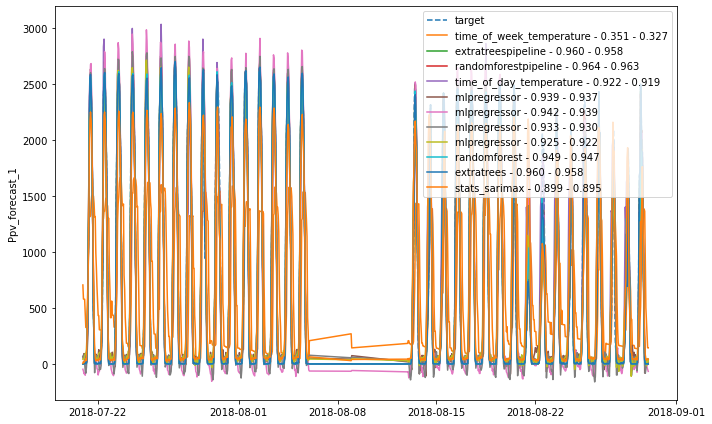

In [5]:
print(a.fcData.sort_values('score', ascending=False))

try:
    a.plotPredictions()
except:
    pass

In [8]:
for d in data.columns: print(d)

Tamb_forecast_1
Tamb_forecast_2
Tamb_forecast_3
Tamb_forecast_4
Tamb_forecast_5
Tamb_forecast_6
Tamb_forecast_7
Tamb_forecast_8
Tamb_forecast_9
Tamb_forecast_10
Tamb_forecast_11
Tamb_forecast_12
Tamb_forecast_13
Tamb_forecast_14
Tamb_forecast_15
Tamb_forecast_16
Tamb_forecast_17
Tamb_forecast_18
Tamb_forecast_19
Tamb_forecast_20
Tamb_forecast_21
Tamb_forecast_22
Tamb_forecast_23
clear_sky_forecast_1
clear_sky_forecast_2
clear_sky_forecast_3
clear_sky_forecast_4
clear_sky_forecast_5
clear_sky_forecast_6
clear_sky_forecast_7
clear_sky_forecast_8
clear_sky_forecast_9
clear_sky_forecast_10
clear_sky_forecast_11
clear_sky_forecast_12
clear_sky_forecast_13
clear_sky_forecast_14
clear_sky_forecast_15
clear_sky_forecast_16
clear_sky_forecast_17
clear_sky_forecast_18
clear_sky_forecast_19
clear_sky_forecast_20
clear_sky_forecast_21
clear_sky_forecast_22
clear_sky_forecast_23
cloud_cover_forecast_1
cloud_cover_forecast_2
cloud_cover_forecast_3
cloud_cover_forecast_4
cloud_cover_forecast_5
cloud_

In [10]:
y_columns

'Ppv_forecast_1'